In [1]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("MongoDB Connection Test") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/CENG_476.joined_data") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/CENG_476.joined_data") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .getOrCreate()

df = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option("uri", "mongodb://localhost:27017/CENG_476.joined_data") \
    .load()

df.printSchema()

df.show(5)


root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- fishing_data_processed: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- weather_data: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- _id: struct (nullable = true)
 |    |    |    |-- oid: string (nullable = true)
 |    |    |-- month: string (nullable = true)
 |    |    |-- parameter: string (nullable = true)
 |    |    |-- mean_value: double (nullable = true)

+--------------------+----------------------+-------+--------------------+
|                 _id|fishing_data_processed|  month|        weather_data|
+--------------------+----------------------+-------+--------------------+
|{6658dbfe14252ca9...|                    23|2023-12|[{{6658dbdb3265e3...|
|{6658dbfe14252ca9...|                    77|2024-01|[{{6658dbdb3265e3...|
|{6658dbfe14252ca9...|                    19|2024-03|[{{6658dbdb3265e3...|
|{6658dbfe14252ca9...|                   

In [32]:
from pyspark.sql.functions import explode, col, avg, corr
import matplotlib.pyplot as plt
import pandas as pd

exploded_df = df.select(col("_id"), col("fishing_data_processed"), explode(col("weather_data")).alias("weather"))

processed_df = exploded_df.select(
    col("_id"),
    col("fishing_data_processed"),
    col("weather.month").alias("month"),
    col("weather.parameter").alias("parameter"),
    col("weather.mean_value").alias("mean_value")
)

processed_df.show(10)


+--------------------+----------------------+-------+--------------------+------------------+
|                 _id|fishing_data_processed|  month|           parameter|        mean_value|
+--------------------+----------------------+-------+--------------------+------------------+
|{6658dbfe14252ca9...|                    23|2023-12|mean_wave_directi...|191.80309139784944|
|{6658dbfe14252ca9...|                    23|2023-12|msl_pressure_mean...|101622.44758064517|
|{6658dbfe14252ca9...|                    23|2023-12|relative_humidity...| 81.68682795698928|
|{6658dbfe14252ca9...|                    23|2023-12|sea_salt_0p03um_0...|3.6414368279569893|
|{6658dbfe14252ca9...|                    23|2023-12|significant_wave_...|1.3079301075268814|
|{6658dbfe14252ca9...|                    23|2023-12|         t_sea_sfc:C|11.741935483870968|
|{6658dbfe14252ca9...|                    23|2023-12|        visibility:m|29483.544892473117|
|{6658dbfe14252ca9...|                    23|2023-12|      w

In [28]:
from pyspark.sql.functions import corr

parameters = processed_df.select("parameter").distinct().rdd.flatMap(lambda x: x).collect()

for param in parameters:
    correlation = processed_df.filter(col("parameter") == param) \
                              .select(corr(col("mean_value"), col("fishing_data_processed")).alias("correlation")) \
                              .collect()[0][0]
    print(f"Correlation between {param} and fishing_data_processed: {correlation}")


Correlation between mean_wave_direction:d and fishing_data_processed: 0.49337384282778174
Correlation between relative_humidity_2m:p and fishing_data_processed: -0.7346059484745383
Correlation between t_10m:C and fishing_data_processed: -0.641081668653049
Correlation between sea_salt_0p03um_0p5um:ugm3 and fishing_data_processed: -0.552800149969508
Correlation between wind_dir_10m:d and fishing_data_processed: 0.5236027250474384
Correlation between msl_pressure_mean_1h:Pa and fishing_data_processed: 0.664302256492937
Correlation between visibility:m and fishing_data_processed: 0.07635673432550535
Correlation between significant_wave_height:m and fishing_data_processed: 0.7357717342661177
Correlation between t_sea_sfc:C and fishing_data_processed: -0.3909404487514293
Correlation between wind_speed_10m:ms and fishing_data_processed: 0.6495405972186591


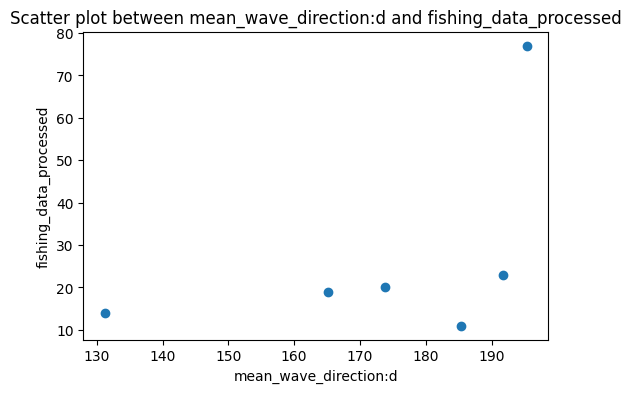

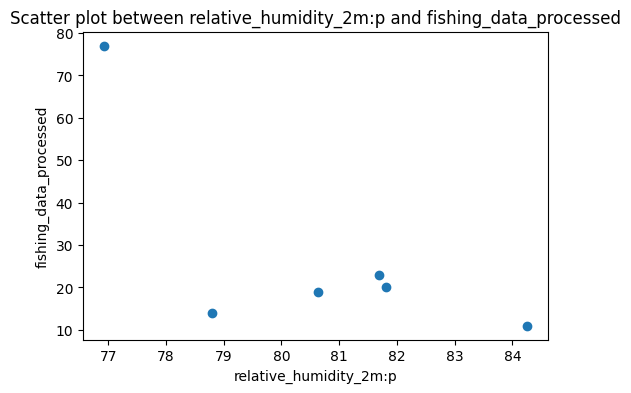

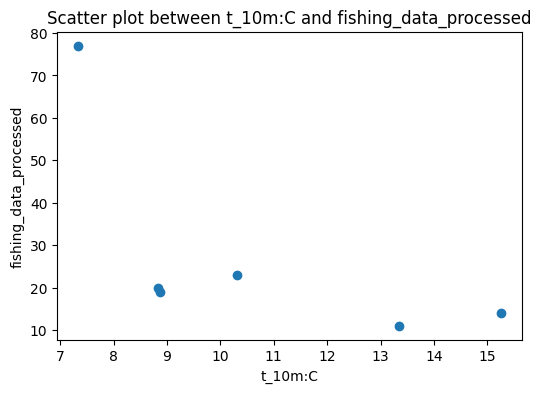

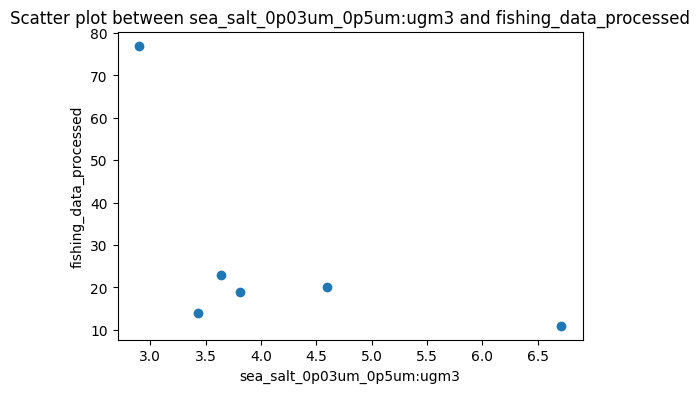

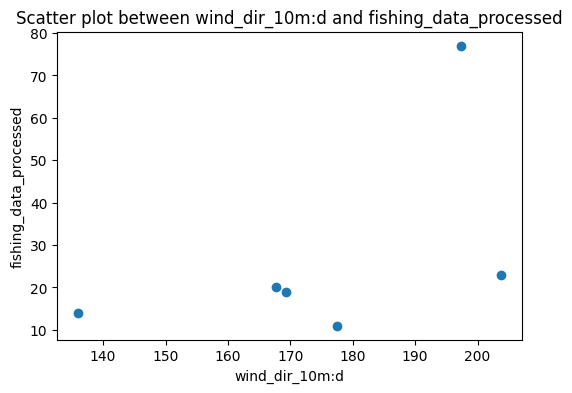

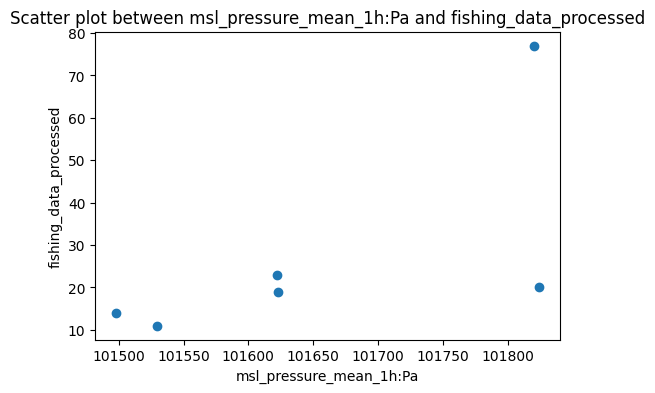

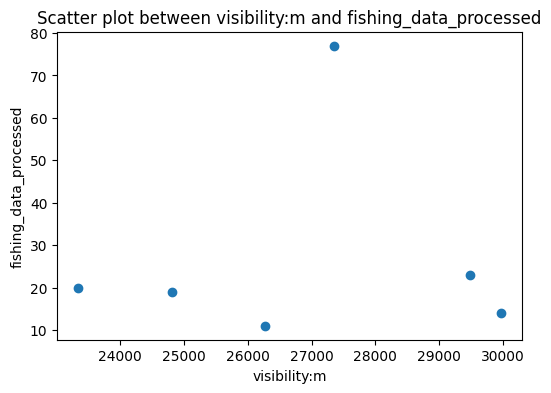

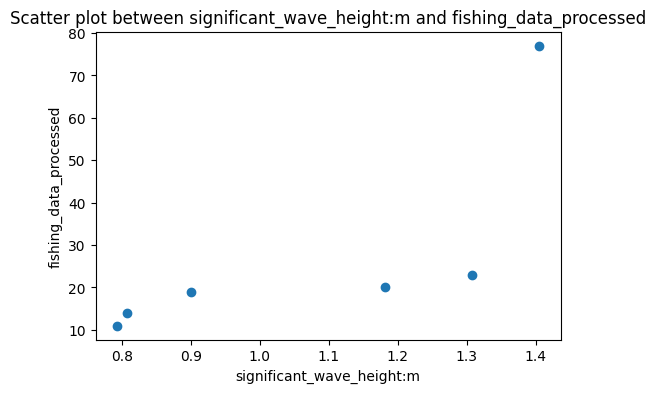

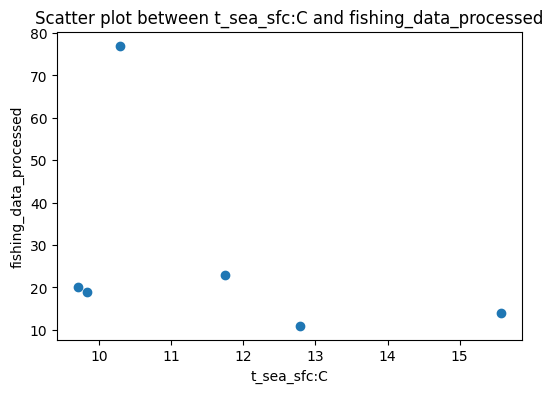

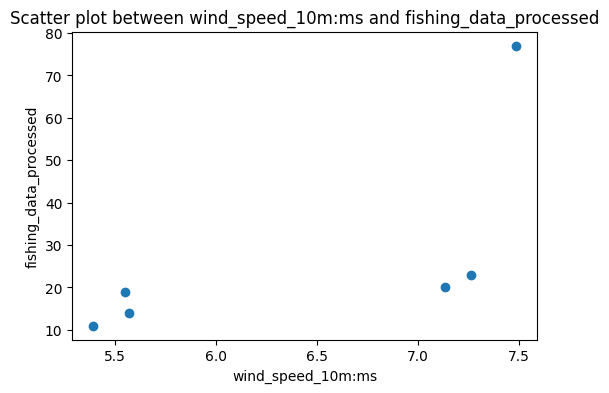

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

pandas_df = processed_df.toPandas()

for param in parameters:
    plt.figure(figsize=(6, 4))
    subset = pandas_df[pandas_df["parameter"] == param]
    plt.scatter(subset["mean_value"], subset["fishing_data_processed"])
    plt.title(f"Scatter plot between {param} and fishing_data_processed")
    plt.xlabel(param)
    plt.ylabel("fishing_data_processed")
    plt.show()


In [66]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, avg, corr
import matplotlib.pyplot as plt
import pandas as pd

def analyze_and_plot_parameter(processed_df, parameter_name):
    filtered_df = processed_df.filter((col("parameter") == parameter_name) & (col("month") >= "2023-07"))
    
    #Correlation
    correlations = filtered_df.groupBy("month").agg(corr("mean_value", "fishing_data_processed").alias("correlation"))
    correlations = correlations.toPandas()

    # Mean of parameter and fishing_data_processed for each month
    mean_values = filtered_df.groupBy("month").agg(avg("mean_value").alias("mean_value"), avg("fishing_data_processed").alias("fishing_data_processed"))
    mean_values = mean_values.toPandas()

    # Merge correlations and mean_values
    result_df = pd.merge(correlations, mean_values, on="month")

    # Sort by month
    result_df["month"] = pd.to_datetime(result_df["month"])
    result_df = result_df.sort_values(by="month")

    # Plotting
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Mean Value
    ax1.plot(result_df["month"].dt.strftime("%Y-%m"), result_df["mean_value"], marker='o', linestyle='-', color='orange', label='Mean Value')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Mean Value', color='orange')
    ax1.tick_params(axis='y', labelcolor='orange')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(loc='upper left')

    # Y-axis for Fishing Data Processed
    ax2 = ax1.twinx()
    ax2.bar(result_df["month"].dt.strftime("%Y-%m"), result_df["fishing_data_processed"], color='green', alpha=0.7, label='Fishing Data Processed')
    ax2.set_ylabel('Fishing Data Processed', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')

    # Actual values
    for i, (mean_value, fishing_data) in enumerate(zip(result_df["mean_value"], result_df["fishing_data_processed"])):
        ax1.text(i, mean_value, f'{mean_value:.2f}', ha='center', va='bottom', fontsize=8, color='orange')
        ax2.text(i, fishing_data, f'{fishing_data:.0f}', ha='center', va='bottom', fontsize=8, color='green')

    plt.title(f'Mean value of {parameter_name} and Fishing Data Processed (Last 6 Months)')
    plt.tight_layout()
    plt.show()


#### 6 Moths Analysis for Wind Speed

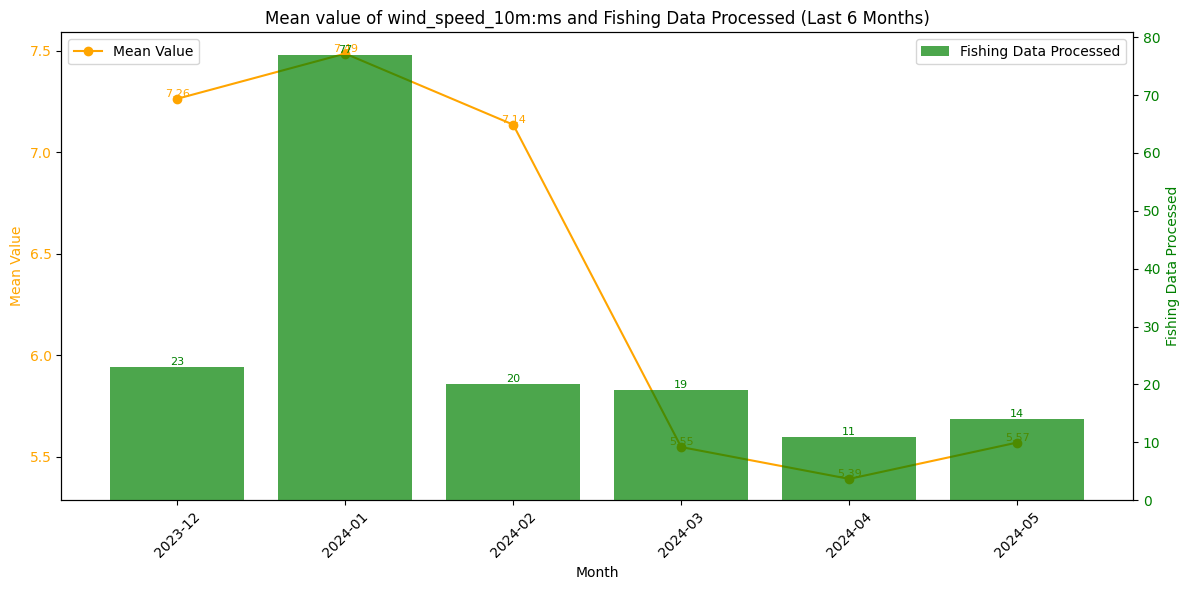

In [67]:
analyze_and_plot_parameter(processed_df, "wind_speed_10m:ms")

#### 6 Moths Analysis for Visibility

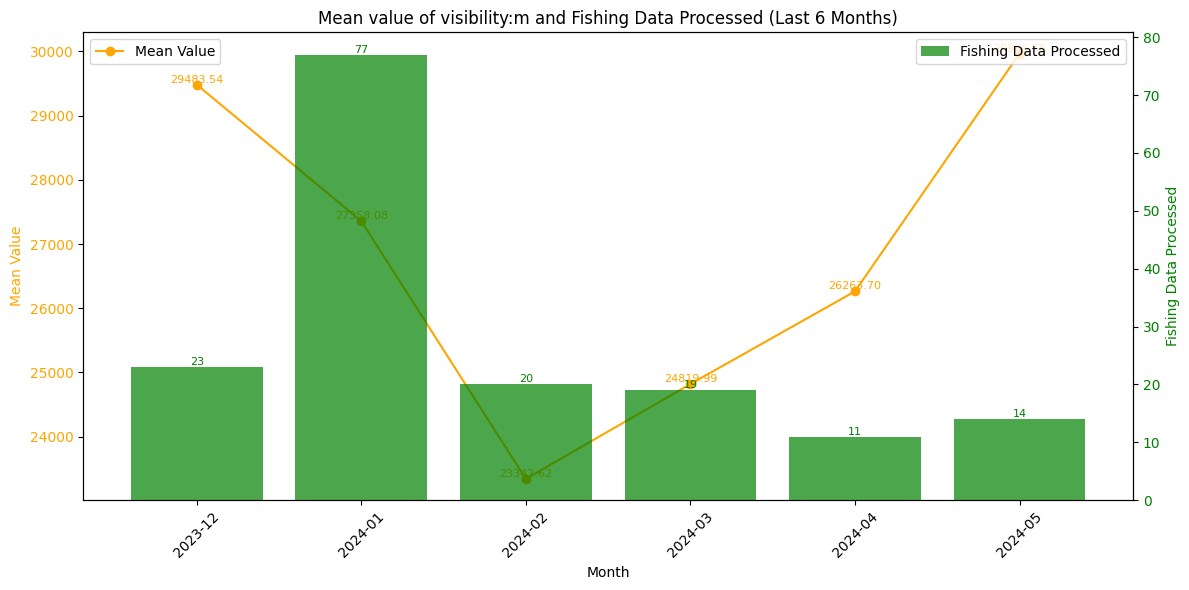

In [44]:
analyze_and_plot_parameter(processed_df, "visibility:m")

#### 6 Moths Analysis for Mean Wave Direction

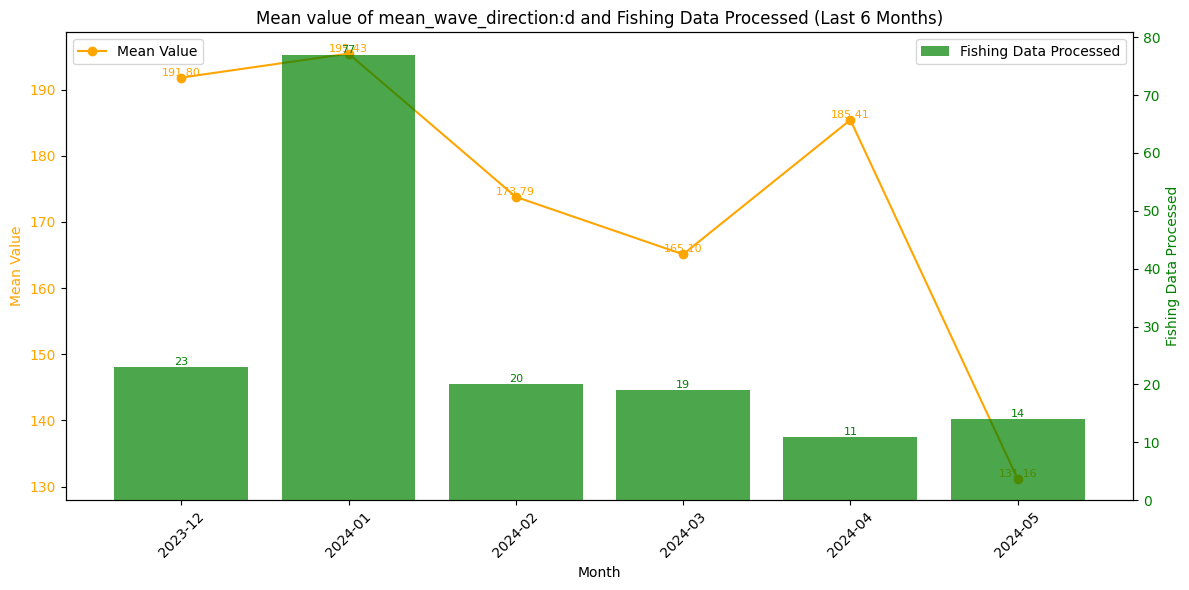

In [45]:
analyze_and_plot_parameter(processed_df, "mean_wave_direction:d")

#### 6 Moths Analysis for Pressure Mean

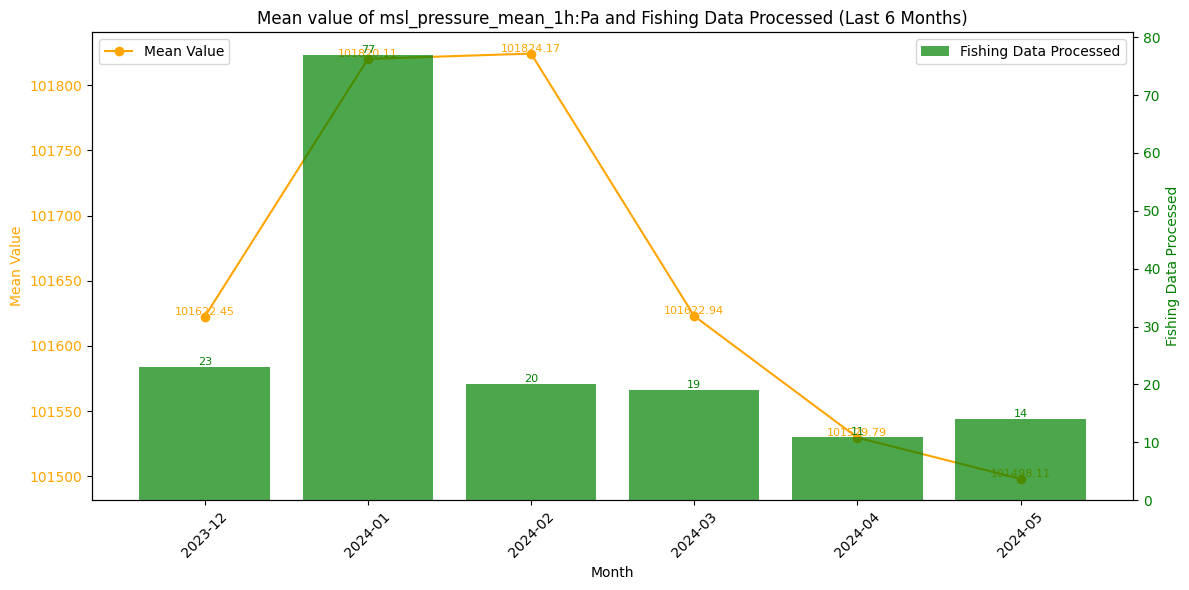

In [46]:
analyze_and_plot_parameter(processed_df, "msl_pressure_mean_1h:Pa")

#### 6 Moths Analysis for Relative Humidity

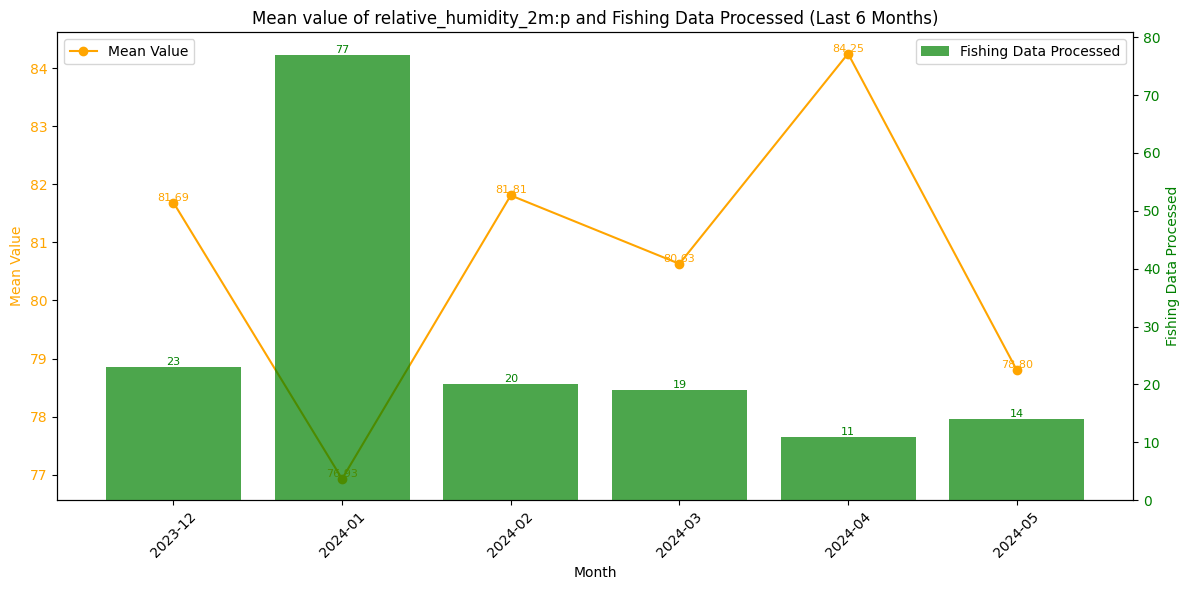

In [47]:
analyze_and_plot_parameter(processed_df, "relative_humidity_2m:p")

#### 6 Moths Analysis for Sea Salt (ph)

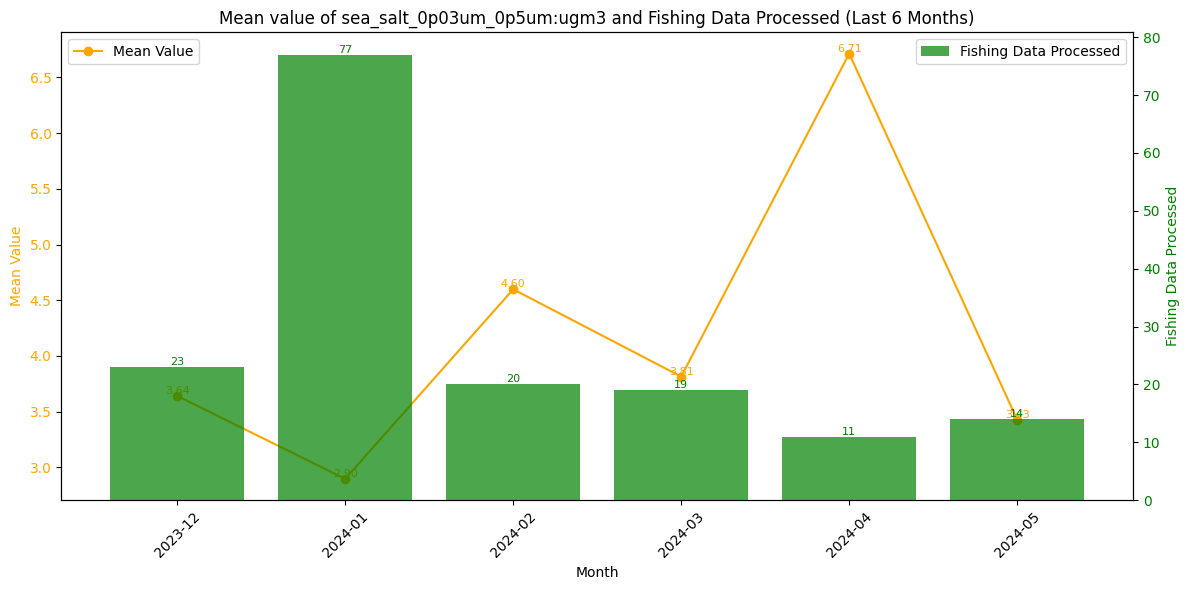

In [48]:
analyze_and_plot_parameter(processed_df, "sea_salt_0p03um_0p5um:ugm3")

#### 6 Moths Analysis for Significant Wave Height

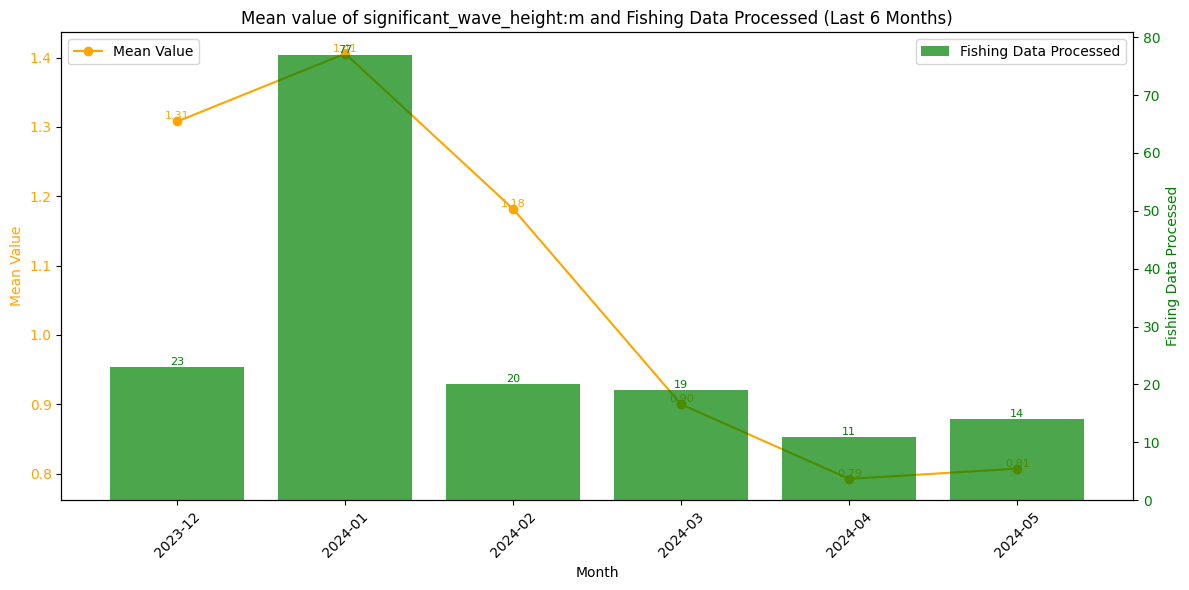

In [53]:
analyze_and_plot_parameter(processed_df, "significant_wave_height:m")

#### 6 Moths Analysis for Sea Surface Temperature

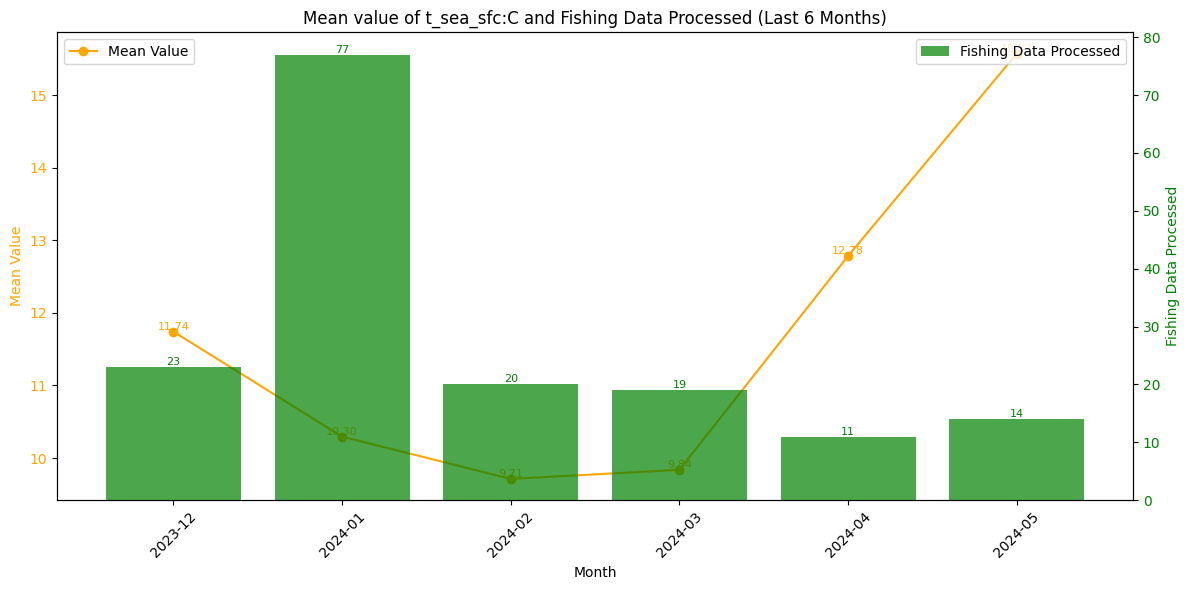

In [50]:
analyze_and_plot_parameter(processed_df, "t_sea_sfc:C")

#### 6 Moths Analysis for Wind Direction

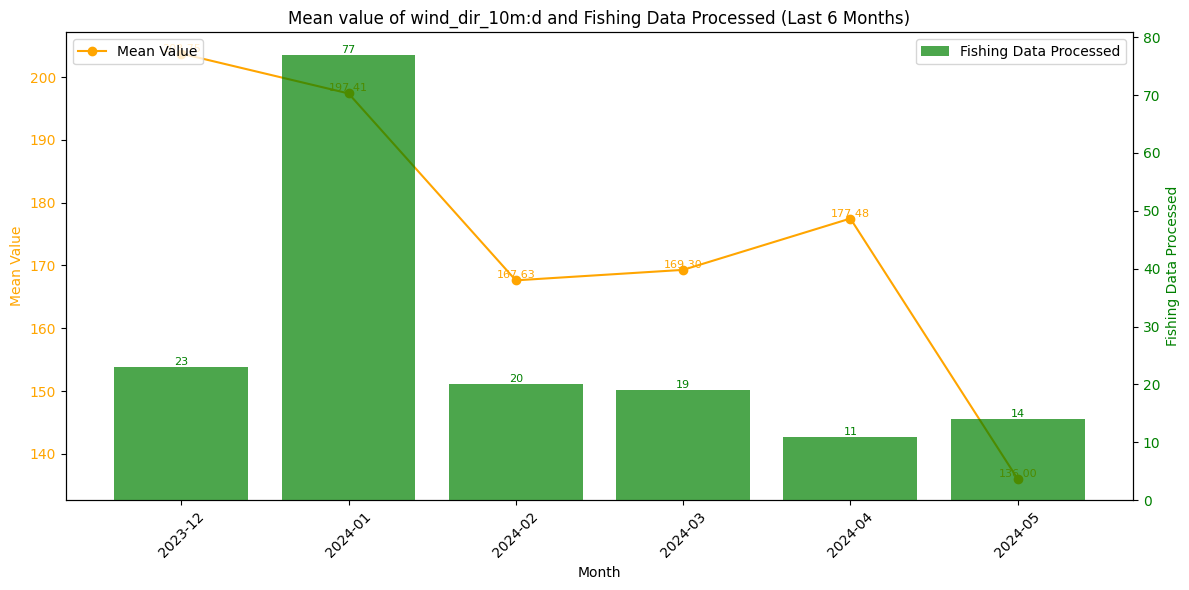

In [51]:
analyze_and_plot_parameter(processed_df, "wind_dir_10m:d")

#### 6 Moths Analysis for Temperature

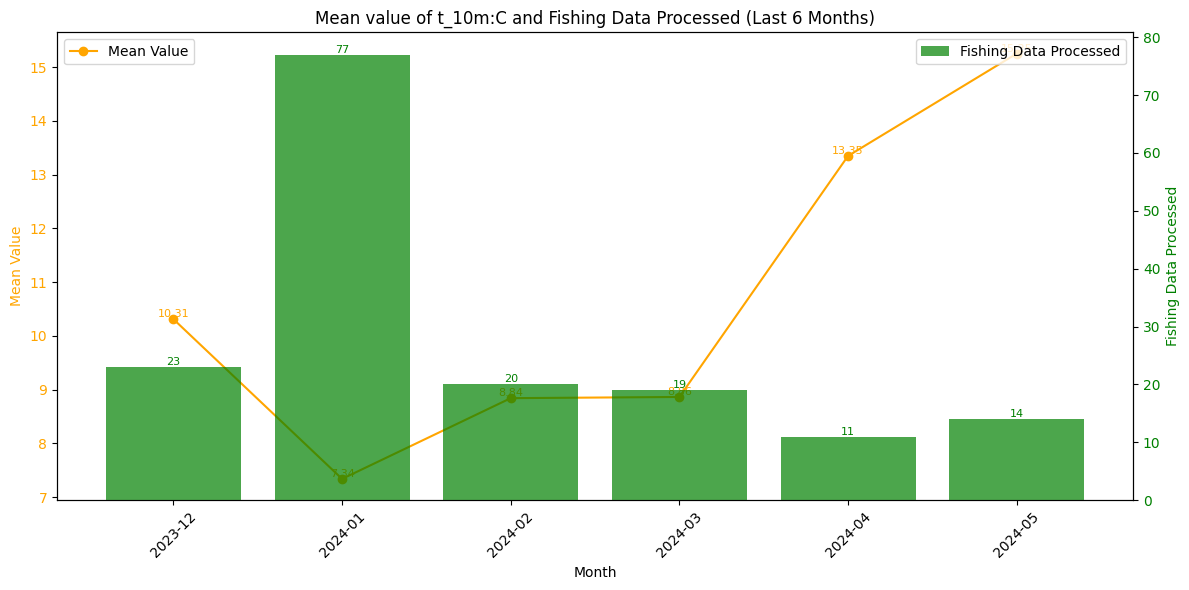

In [52]:
analyze_and_plot_parameter(processed_df, "t_10m:C")

### AGGREGATED AND PIVOTED TABLES

In [74]:
from pyspark.sql.functions import col, explode, collect_list, first
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import DoubleType

aggregated_df = processed_df.groupBy("_id", "fishing_data_processed", "month").pivot("parameter").agg(collect_list("mean_value")).fillna(0)
aggregated_df.show(5)

+--------------------+----------------------+-------+---------------------+-----------------------+----------------------+--------------------------+-------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 _id|fishing_data_processed|  month|mean_wave_direction:d|msl_pressure_mean_1h:Pa|relative_humidity_2m:p|sea_salt_0p03um_0p5um:ugm3|significant_wave_height:m|             t_10m:C|         t_sea_sfc:C|        visibility:m|      wind_dir_10m:d|   wind_speed_10m:ms|
+--------------------+----------------------+-------+---------------------+-----------------------+----------------------+--------------------------+-------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|{6658dbfe14252ca9...|                    23|2023-12| [191.80309139784944]|   [101622.44758064517]|   [81.68682795698928]|      [3.6414368279569893]|     [1.

In [75]:
pivoted_df = processed_df.groupBy("_id", "fishing_data_processed", "month").pivot("parameter").agg(first("mean_value")).fillna(0)
pivoted_df.show(5)

+--------------------+----------------------+-------+---------------------+-----------------------+----------------------+--------------------------+-------------------------+------------------+------------------+------------------+------------------+------------------+
|                 _id|fishing_data_processed|  month|mean_wave_direction:d|msl_pressure_mean_1h:Pa|relative_humidity_2m:p|sea_salt_0p03um_0p5um:ugm3|significant_wave_height:m|           t_10m:C|       t_sea_sfc:C|      visibility:m|    wind_dir_10m:d| wind_speed_10m:ms|
+--------------------+----------------------+-------+---------------------+-----------------------+----------------------+--------------------------+-------------------------+------------------+------------------+------------------+------------------+------------------+
|{6658dbfe14252ca9...|                    23|2023-12|   191.80309139784944|     101622.44758064517|     81.68682795698928|        3.6414368279569893|       1.3079301075268814|10.311424731

# Weather Data Prediction

In [105]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, to_date, month
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd

weather_df = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option("uri", "mongodb://localhost:27017/CENG_476.weather_daily_means") \
    .load()

weather_df.show(5)


+--------------------+----------+------------------+--------------------+
|                 _id|      date|        mean_value|           parameter|
+--------------------+----------+------------------+--------------------+
|{6658dbda3265e32b...|2023-11-30|133.70000000000002|mean_wave_directi...|
|{6658dbda3265e32b...|2023-12-01|211.20416666666668|mean_wave_directi...|
|{6658dbda3265e32b...|2023-12-02|244.17083333333335|mean_wave_directi...|
|{6658dbda3265e32b...|2023-12-03|247.98333333333332|mean_wave_directi...|
|{6658dbda3265e32b...|2023-12-04|109.32083333333331|mean_wave_directi...|
+--------------------+----------+------------------+--------------------+
only showing top 5 rows



In [117]:
def predict_next_month_mean(spark, weather_df, parameter_name):

    #Specific Parameter
    filtered_df = weather_df.filter(col("parameter") == parameter_name)

    # Convert date
    filtered_df = filtered_df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
    filtered_df = filtered_df.withColumn("month", month(col("date")))

    # Create lagged features
    w = Window.partitionBy().orderBy("date")
    lagged_df = filtered_df.withColumn("mean_value_lag1", lag("mean_value", 1).over(w))
    lagged_df = lagged_df.withColumn("mean_value_lag2", lag("mean_value", 2).over(w))
    lagged_df = lagged_df.withColumn("mean_value_lag3", lag("mean_value", 3).over(w))

    # Drop rows with null values
    lagged_df = lagged_df.na.drop()

    # Vector assembler
    assembler = VectorAssembler(
        inputCols=["mean_value_lag1", "mean_value_lag2", "mean_value_lag3"],
        outputCol="features")

    # Transform the data
    assembled_df = assembler.transform(lagged_df)

    # Training and test sets
    train_data = assembled_df.filter(col("month") < 5)
    test_data = assembled_df.filter(col("month") == 5)

    # Linear Regression model training
    lr = LinearRegression(featuresCol="features", labelCol="mean_value")
    lr_model = lr.fit(train_data)

    # Make predictions for the test data (May)
    predictions = lr_model.transform(test_data)

    # Evaluate
    evaluator = RegressionEvaluator(labelCol="mean_value", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

    # Predictions
    predictions_pd = predictions.select("date", "mean_value", "prediction").orderBy("date").toPandas()

    # Actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(predictions_pd["date"], predictions_pd["mean_value"], marker='o', color='blue', label='Actual')
    plt.plot(predictions_pd["date"], predictions_pd["prediction"], marker='x', color='red', linestyle='--', label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Mean Value')
    plt.title(f'Actual vs Predicted Mean Value for {parameter_name}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Prediction for Mean Wave Direction - May

Root Mean Squared Error (RMSE) on test data: 65.42354718461526


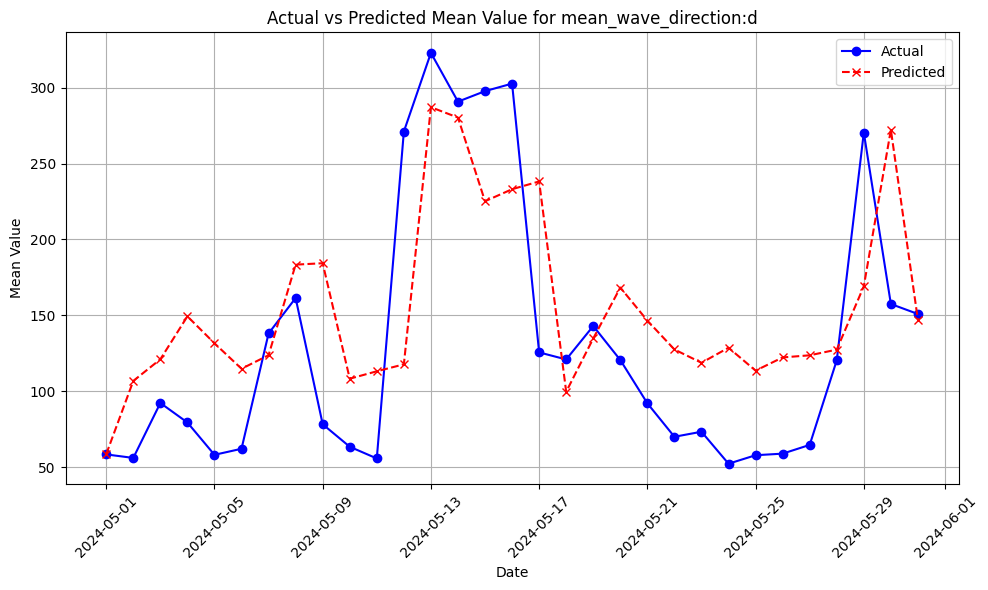

In [118]:
predict_next_month_mean(spark, weather_df, "mean_wave_direction:d")

### Prediction for MSL Pressure - May

Root Mean Squared Error (RMSE) on test data: 224.84216695243873


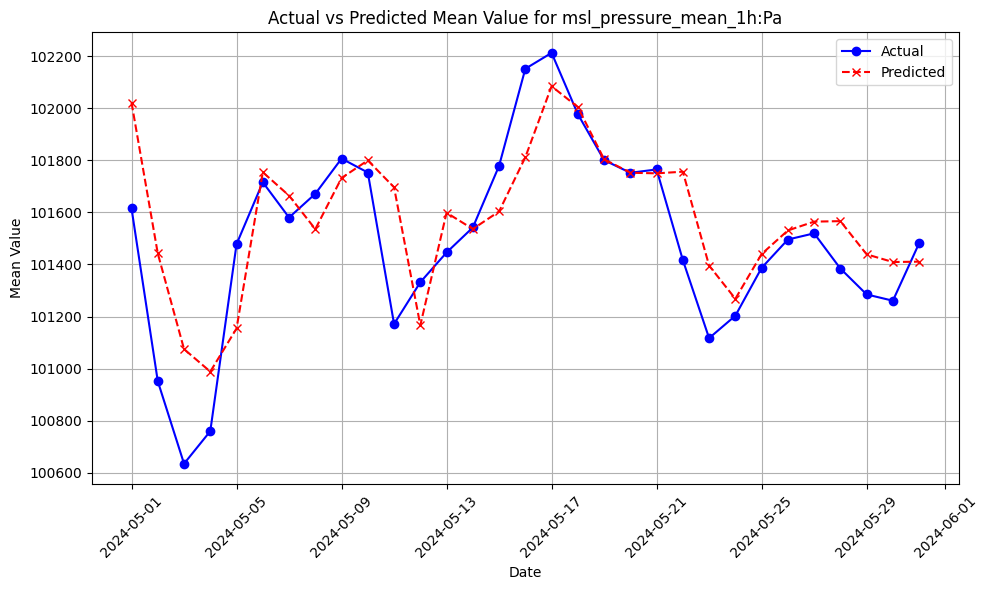

In [119]:
predict_next_month_mean(spark, weather_df, "msl_pressure_mean_1h:Pa")

### Prediction for Relative Humidity - May

Root Mean Squared Error (RMSE) on test data: 8.014996888009785


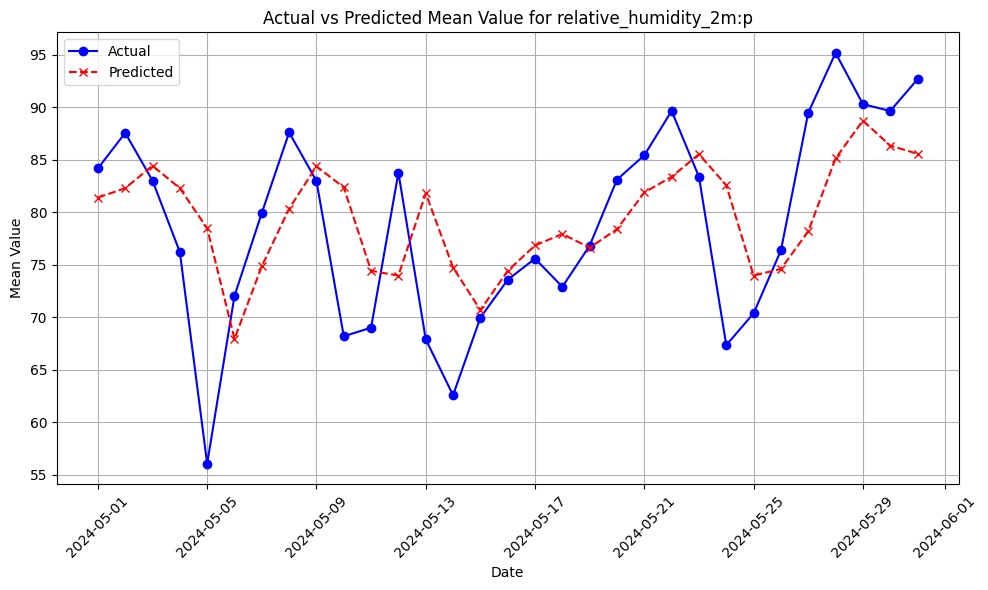

In [120]:
predict_next_month_mean(spark, weather_df, "relative_humidity_2m:p")

### Prediction for Sea Salt (ph) - May

Root Mean Squared Error (RMSE) on test data: 1.1358234004754302


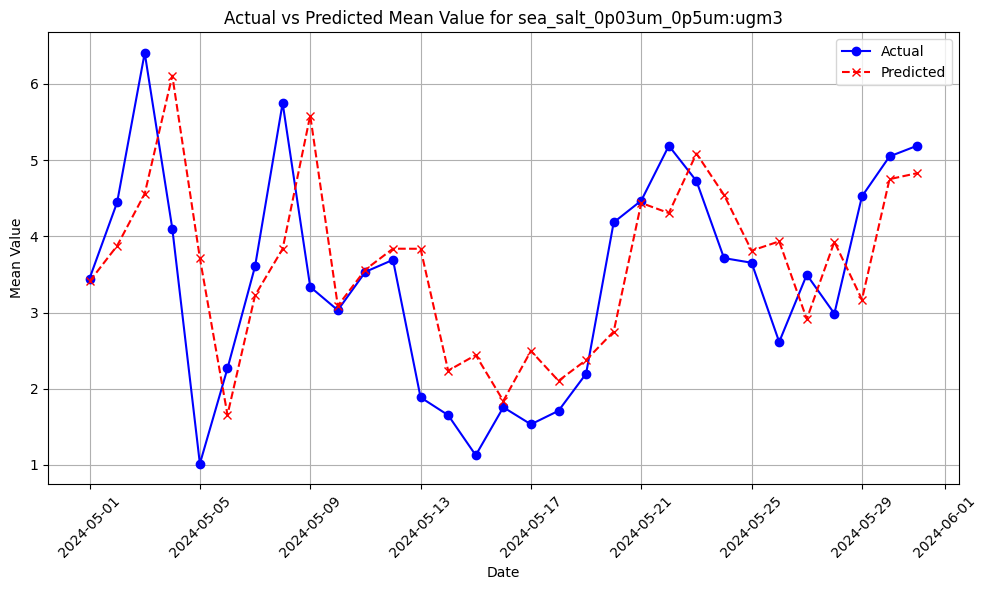

In [121]:
predict_next_month_mean(spark, weather_df, "sea_salt_0p03um_0p5um:ugm3")

### Prediction for Significant Wave Height - May

Root Mean Squared Error (RMSE) on test data: 0.4740467714746495


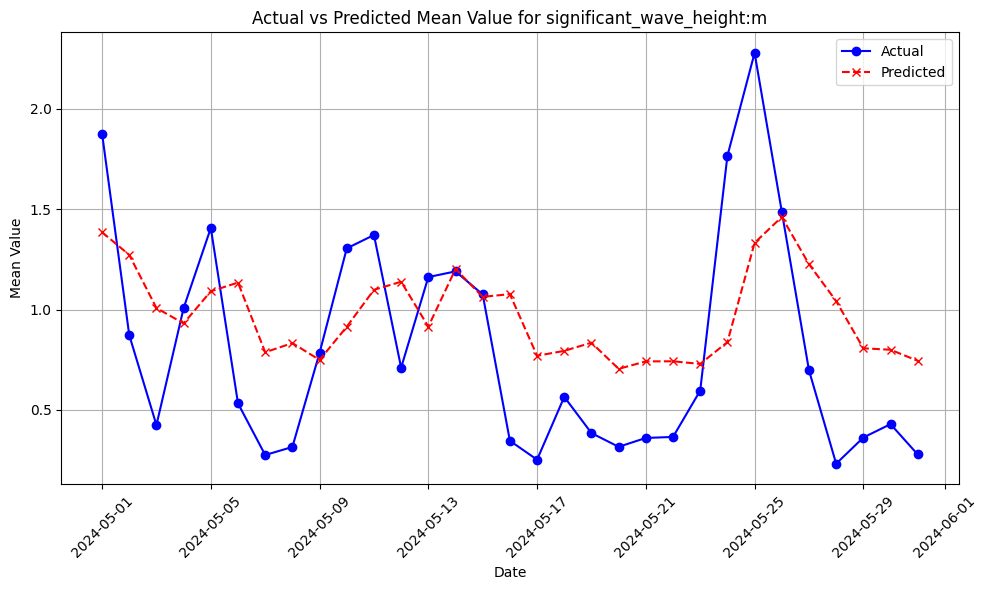

In [122]:
predict_next_month_mean(spark, weather_df, "significant_wave_height:m")

### Prediction for Sea Surface Temperature - May

Root Mean Squared Error (RMSE) on test data: 0.6374811558798483


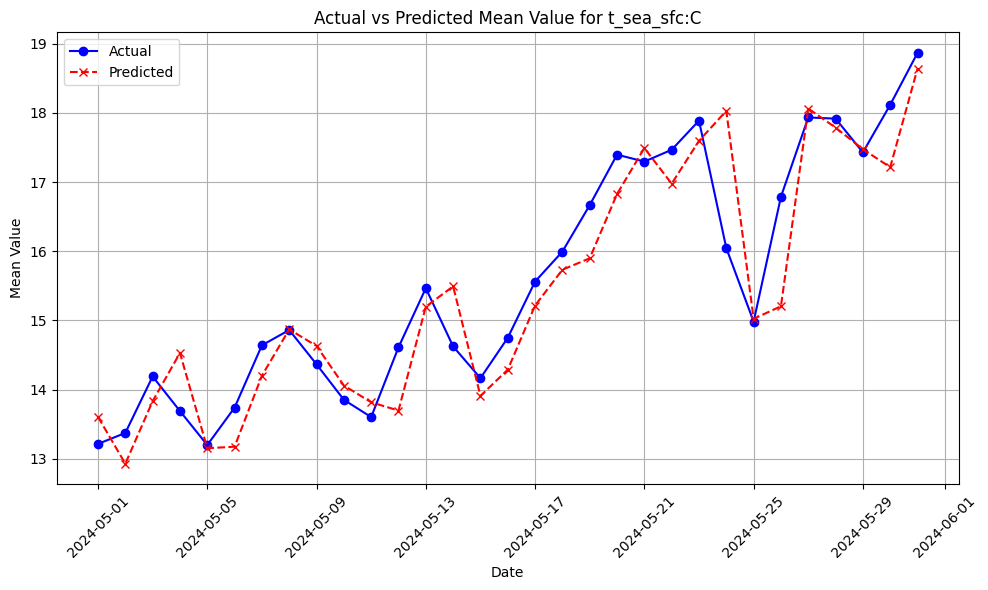

In [123]:
predict_next_month_mean(spark, weather_df, "t_sea_sfc:C")

### Prediction for Visibility - May

Root Mean Squared Error (RMSE) on test data: 3903.3483322336238


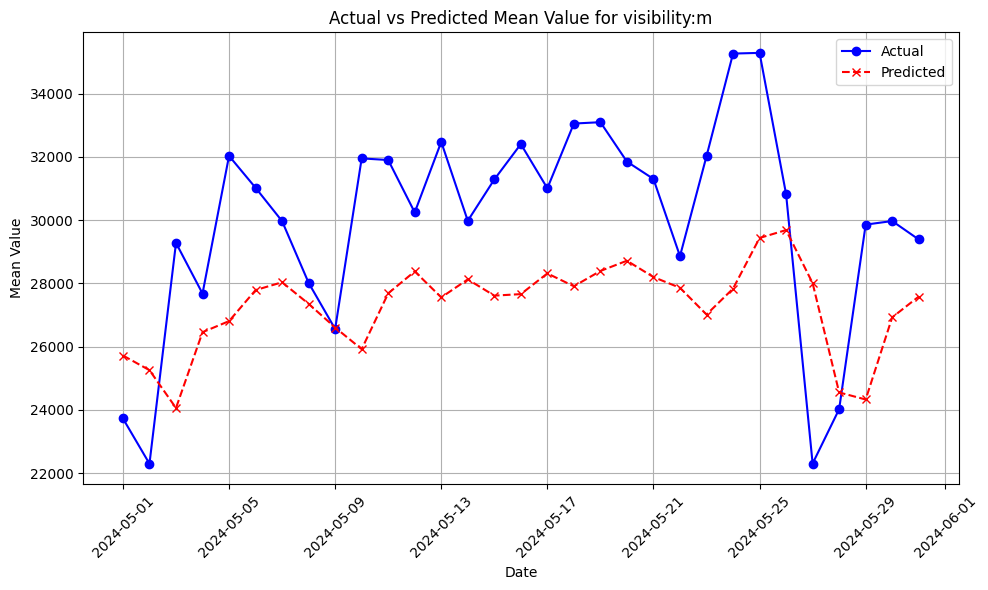

In [124]:
predict_next_month_mean(spark, weather_df, "visibility:m")

### Prediction for Wind Direction - May

Root Mean Squared Error (RMSE) on test data: 68.51054888819887


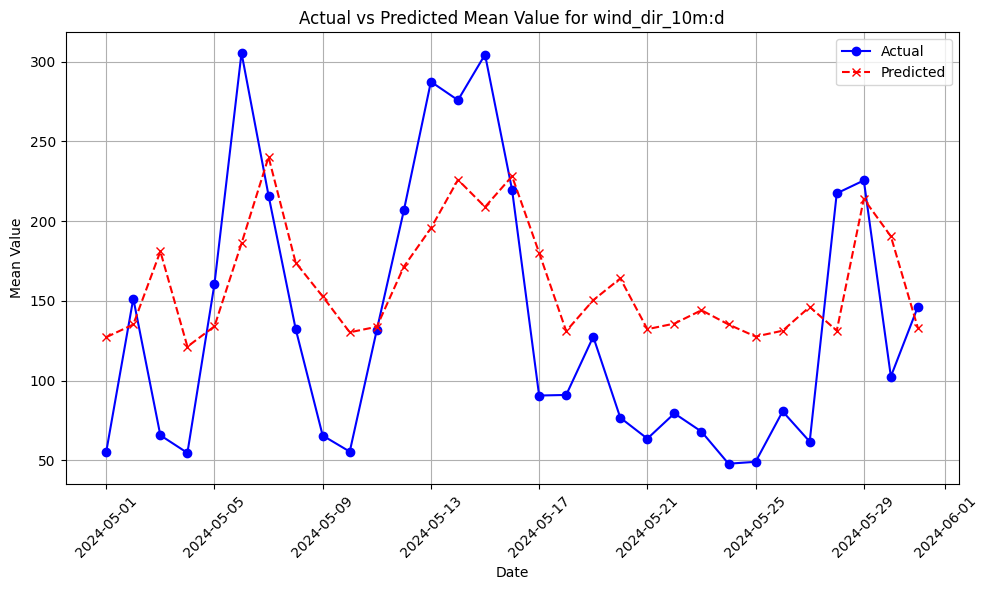

In [125]:
predict_next_month_mean(spark, weather_df, "wind_dir_10m:d")

### Prediction for Wind Speed - May

Root Mean Squared Error (RMSE) on test data: 2.576142187916458


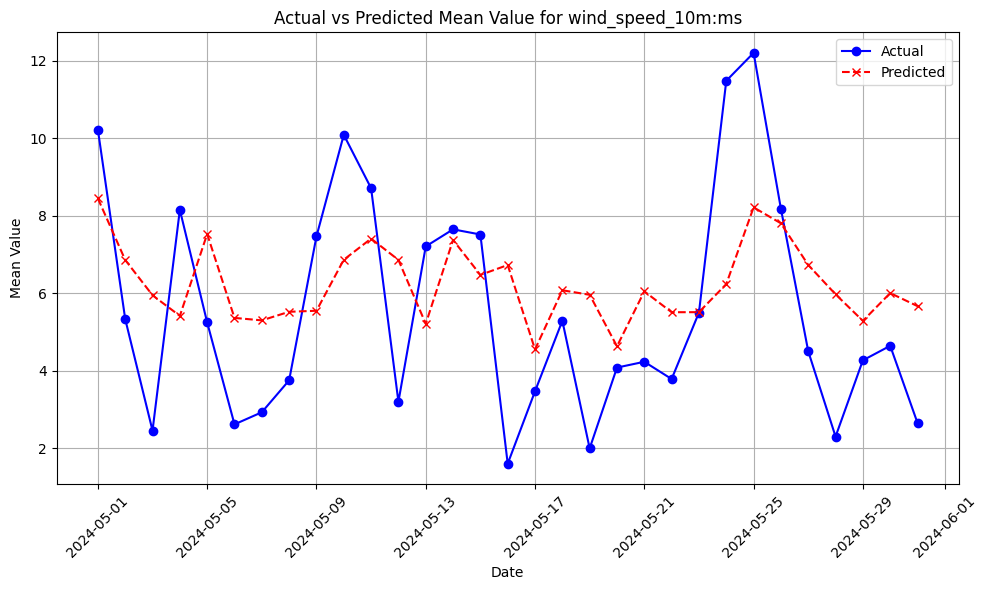

In [126]:
predict_next_month_mean(spark, weather_df, "wind_speed_10m:ms")

### Prediction for Temperature - May

Root Mean Squared Error (RMSE) on test data: 0.9068861449383413


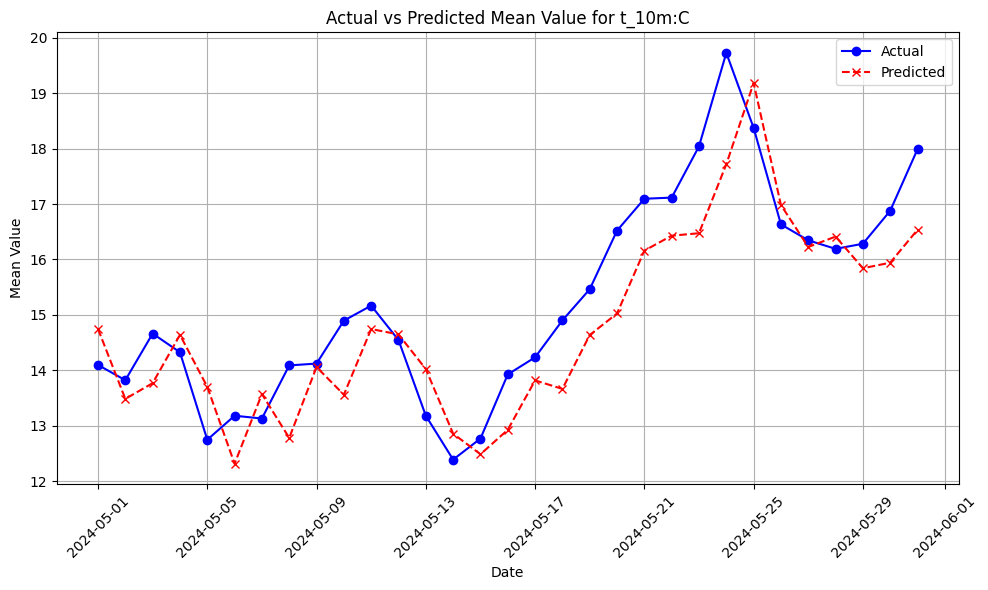

In [127]:
predict_next_month_mean(spark, weather_df, "t_10m:C")

### PySpark Regression with Fishing Data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("FishingEventsPrediction").getOrCreate()

data_path = "data_summary.csv"
fishing_df = spark.read.csv(data_path, header=True, inferSchema=True)

fishing_df.show()


+----------+-----+
|      Date|Total|
+----------+-----+
|2014-01-01|   15|
|2014-02-01|   17|
|2014-03-01|   26|
|2014-04-01|    5|
|2014-05-01|    0|
|2014-06-01|    0|
|2014-07-01|    0|
|2014-08-01|    0|
|2014-09-01|  208|
|2014-10-01|   91|
|2014-11-01|  108|
|2014-12-01|  355|
|2015-01-01|   41|
|2015-02-01|  106|
|2015-03-01|   17|
|2015-04-01|    9|
|2015-05-01|    0|
|2015-06-01|    0|
|2015-07-01|    0|
|2015-08-01|    0|
+----------+-----+
only showing top 20 rows



In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_unixtime, expr, add_months
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

#Spark session
spark = SparkSession.builder.appName("FishingEventsPrediction").getOrCreate()

data_path = "data_summary.csv"
fishing_df = spark.read.csv(data_path, header=True, inferSchema=True)

fishing_df = fishing_df.withColumn("Date", expr("unix_timestamp(Date, 'yyyy-MM-dd')"))

fishing_df = fishing_df.orderBy("Date")

fishing_df.printSchema()

# Feature column
assembler = VectorAssembler(inputCols=["Date"], outputCol="features")
fishing_df = assembler.transform(fishing_df)

# Training and test sets
train_data, test_data = fishing_df.randomSplit([0.8, 0.2], seed=42)

# Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Total")

# Fit the model
lr_model = lr.fit(train_data)

# Print the model summary
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

# Evaluate the model on test data
test_results = lr_model.evaluate(test_data)
print(f"Root Mean Squared Error (RMSE): {test_results.rootMeanSquaredError}")
print(f"R2: {test_results.r2}")

# Make predictions on the test data
predictions = lr_model.transform(test_data)

predictions = predictions.withColumn("Date", from_unixtime(col("Date"), "yyyy-MM-dd"))

predictions.select("Date", "Total", "prediction").show()

future_dates = spark.createDataFrame([(i,) for i in range(1, 13)], ["month"])
future_dates = future_dates.withColumn("Date", add_months(expr("to_date('2023-12-01')"), col("month")))

future_dates = future_dates.withColumn("Date", expr("unix_timestamp(Date, 'yyyy-MM-dd')"))

future_dates = assembler.transform(future_dates)

# Make predictions on future dates
future_predictions = lr_model.transform(future_dates)

future_predictions = future_predictions.withColumn("Date", from_unixtime(col("Date"), "yyyy-MM-dd"))

# Show future predictions
future_predictions.select("Date", "prediction").show()


root
 |-- Date: long (nullable = true)
 |-- Total: integer (nullable = true)

Coefficients: [-1.2395979923155225e-07]
Intercept: 229.1804594233557
Root Mean Squared Error (RMSE): 73.68274051984154
R2: 0.06330531660322547
+----------+-----+------------------+
|      Date|Total|        prediction|
+----------+-----+------------------+
|2014-03-01|   26| 56.42700901124354|
|2014-07-01|    0|55.120819814780816|
|2014-09-01|  208|54.456791962257256|
|2015-02-01|  106|52.817696328978286|
|2015-08-01|    0| 50.87960965995282|
|2015-12-01|    7|49.572527952935616|
|2016-06-01|    0| 47.61302103060294|
|2016-12-01|    9| 45.65306785299302|
|2017-10-01|    9| 42.39718935029677|
|2017-11-01|  311|42.065175424034976|
|2017-12-01|   63| 41.74387162442679|
|2018-02-01|   17|  41.0798437719032|
|2018-04-01|   14| 40.44794629934046|
|2018-08-01|    0|39.141310847600494|
|2019-03-01|    9| 36.87076399703602|
|2019-10-01|    0| 34.57879689316431|
|2020-06-01|    0| 31.96552598968441|
|2022-05-01|    0|2

### Storing Predictions in the MongoDB

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_unixtime, expr, add_months
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pymongo import MongoClient

# Spark session
spark = SparkSession.builder.appName("FishingEventsPrediction").getOrCreate()

data_path = "data_summary.csv"
fishing_df = spark.read.csv(data_path, header=True, inferSchema=True)

fishing_df = fishing_df.withColumn("Date", expr("unix_timestamp(Date, 'yyyy-MM-dd')"))

# Order by Date
fishing_df = fishing_df.orderBy("Date")

# Feature column
assembler = VectorAssembler(inputCols=["Date"], outputCol="features")
fishing_df = assembler.transform(fishing_df)

# Training and test sets
train_data, test_data = fishing_df.randomSplit([0.8, 0.2], seed=42)

# Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Total")

# Fit the model
lr_model = lr.fit(train_data)

# Print the model summary
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

# Evaluate the model on test data
test_results = lr_model.evaluate(test_data)
print(f"Root Mean Squared Error (RMSE): {test_results.rootMeanSquaredError}")
print(f"R2: {test_results.r2}")

# Make predictions on the test data
predictions = lr_model.transform(test_data)

predictions = predictions.withColumn("Date", from_unixtime(col("Date"), "yyyy-MM-dd"))

# Show predictions
predictions.show()

# Create future dates
future_dates = spark.createDataFrame([(i,) for i in range(1, 13)], ["month"])
future_dates = future_dates.withColumn("Date", add_months(expr("to_date('2023-12-01')"), col("month")))
future_dates = future_dates.withColumn("Date", expr("unix_timestamp(Date, 'yyyy-MM-dd')"))
future_dates = assembler.transform(future_dates)

# Make predictions on future dates
future_predictions = lr_model.transform(future_dates)

future_predictions = future_predictions.withColumn("Date", from_unixtime(col("Date"), "yyyy-MM-dd"))

# Show future predictions
future_predictions.show()

predictions_df = predictions.select("Date", "prediction").toPandas()
future_predictions_df = future_predictions.select("Date", "prediction").toPandas()

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["CENG_476"]
collection = db["fishing_predictions"]

predictions_data = predictions_df.to_dict(orient="records")
future_predictions_data = future_predictions_df.to_dict(orient="records")

# Insert data into MongoDB
collection.insert_many(predictions_data)
collection.insert_many(future_predictions_data)

# Close MongoDB connection
client.close()


Coefficients: [-1.2395979923155225e-07]
Intercept: 229.1804594233557
Root Mean Squared Error (RMSE): 73.68274051984154
R2: 0.06330531660322547
+----------+-----+-------------+------------------+
|      Date|Total|     features|        prediction|
+----------+-----+-------------+------------------+
|2014-03-01|   26|[1.3936248E9]| 56.42700901124354|
|2014-07-01|    0| [1.404162E9]|55.120819814780816|
|2014-09-01|  208|[1.4095188E9]|54.456791962257256|
|2015-02-01|  106|[1.4227416E9]|52.817696328978286|
|2015-08-01|    0|[1.4383764E9]| 50.87960965995282|
|2015-12-01|    7|[1.4489208E9]|49.572527952935616|
|2016-06-01|    0|[1.4647284E9]| 47.61302103060294|
|2016-12-01|    9|[1.4805396E9]| 45.65306785299302|
|2017-10-01|    9|[1.5068052E9]| 42.39718935029677|
|2017-11-01|  311|[1.5094836E9]|42.065175424034976|
|2017-12-01|   63|[1.5120756E9]| 41.74387162442679|
|2018-02-01|   17|[1.5174324E9]|  41.0798437719032|
|2018-04-01|   14|  [1.52253E9]| 40.44794629934046|
|2018-08-01|    0|[1.5330